# 1. Lectura del dataset con pandas

In [1]:
import pandas as pd
import os
import numpy as np # version 1.26.4 (pip install numpy==1.26.4)
from sklearn.impute import KNNImputer
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings

In [2]:
carpeta = 'dataset_historico_id_3195'
lista_data = os.listdir(carpeta)

fichero = max(list(filter(lambda x: x.endswith('.jsonl'), lista_data)))

ruta = os.path.join(carpeta, fichero)
df = pd.read_json(ruta, lines = True)
df

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,...,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,presMax,horaPresMax,presMin,horaPresMin,sol
0,2024-10-05,3195,"MADRID, RETIRO",MADRID,667,"19,1","0,0","12,8",06:00,"25,4",...,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-06,3195,"MADRID, RETIRO",MADRID,667,"20,1","0,0","17,6",05:00,"22,6",...,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-07,3195,"MADRID, RETIRO",MADRID,667,"18,2","6,5","13,8",18:50,"22,5",...,81.0,97.0,Varias,43.0,12:10,NaN,NaN,NaN,NaN,NaN
3,2024-10-08,3195,"MADRID, RETIRO",MADRID,667,"15,0","0,4","12,7",05:00,"17,4",...,85.0,96.0,01:10,73.0,12:50,NaN,NaN,NaN,NaN,NaN
4,2024-10-09,3195,"MADRID, RETIRO",MADRID,667,"16,6","4,7","13,8",23:59,"19,5",...,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38406,1920-03-09,3195,"MADRID, RETIRO",MADRID,667,"1,8",Ip,"-0,7",06:00,"4,4",...,46.0,NaN,NaN,NaN,NaN,"951,7",23,"945,7",03,"8,2"
38407,1920-03-10,3195,"MADRID, RETIRO",MADRID,667,"3,5","0,0","-0,6",03:00,"7,6",...,55.0,NaN,NaN,NaN,NaN,"951,5",00,"949,1",14,"6,7"
38408,1920-03-11,3195,"MADRID, RETIRO",MADRID,667,"5,4","0,0","-1,8",05:00,"12,7",...,57.0,NaN,NaN,NaN,NaN,"951,2",09,"948,6",16,"10,0"
38409,1920-03-12,3195,"MADRID, RETIRO",MADRID,667,"10,5","0,0","5,9",00:15,"15,1",...,NaN,NaN,NaN,NaN,NaN,"949,5",10,"947,3",24,"5,7"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38411 entries, 0 to 38410
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fecha        38411 non-null  object 
 1   indicativo   38411 non-null  int64  
 2   nombre       38411 non-null  object 
 3   provincia    38411 non-null  object 
 4   altitud      38411 non-null  int64  
 5   tmed         38275 non-null  object 
 6   prec         37446 non-null  object 
 7   tmin         38275 non-null  object 
 8   horatmin     37391 non-null  object 
 9   tmax         38277 non-null  object 
 10  horatmax     37425 non-null  object 
 11  dir          29913 non-null  float64
 12  velmedia     32983 non-null  object 
 13  racha        30004 non-null  object 
 14  horaracha    29631 non-null  object 
 15  hrMedia      37038 non-null  float64
 16  hrMax        5952 non-null   float64
 17  horaHrMax    5952 non-null   object 
 18  hrMin        5951 non-null   float64
 19  hora

# 2. Pre-procesamiento

Los campos indicativo, nombre, provincia y altitud son los mismos para todos los registros, por lo que no es necesario incluirlos en el dataframe.m

In [4]:
df = df[df.columns[5:].insert(0, 'fecha')] # Se filtra el dataframe para que contenga solo las columnas de interés

Se pone en formato fecha la columna de fechas, que va a ser el campo índice

In [5]:
df["fecha"] = pd.to_datetime(df["fecha"])
df.set_index("fecha", inplace=True)
df.sort_index(inplace=True, ascending=False)

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\2099670388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fecha"] = pd.to_datetime(df["fecha"])
C:\Users\felix\AppData\Local\Temp\ipykernel_4508\2099670388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_index(inplace=True, ascending=False)


Hay campos numericos que pandas lee como texto debido a que el decimal es una coma y no un punto. Por lo tanto, se sustituye las comas por puntos. Además, interesa poner el formato hora en formato numérico

In [6]:
df.replace(',','.', regex=True, inplace=True)
df.replace(':','.', regex = True, inplace = True) 
# Se reemplazan las comas por puntos y los dos puntos por puntos para poder convertir a float
columnas_numericas = ['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'racha', 'presMax', 'presMin', 'sol']
for col in columnas_numericas:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.info()

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\3586366732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(',','.', regex=True, inplace=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38411 entries, 2025-04-03 to 1920-01-01
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tmed         38275 non-null  float64
 1   prec         36038 non-null  float64
 2   tmin         38275 non-null  float64
 3   horatmin     37391 non-null  object 
 4   tmax         38277 non-null  float64
 5   horatmax     37425 non-null  object 
 6   dir          29913 non-null  float64
 7   velmedia     32983 non-null  float64
 8   racha        30004 non-null  float64
 9   horaracha    29631 non-null  object 
 10  hrMedia      37038 non-null  float64
 11  hrMax        5952 non-null   float64
 12  horaHrMax    5952 non-null   object 
 13  hrMin        5951 non-null   float64
 14  horaHrMin    5950 non-null   object 
 15  presMax      36948 non-null  float64
 16  horaPresMax  36948 non-null  object 
 17  presMin      36948 non-null  float64
 18  horaPresMin  36946 non-null  

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\3586366732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(':','.', regex = True, inplace = True)
C:\Users\felix\AppData\Local\Temp\ipykernel_4508\3586366732.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


Hay campos cuyo valor es igual a "varias". Se reemplaza el valor 'Varias' por NaN para poder convertir a float los campos de horas y porque se decide que no es suficientemente informativo

In [7]:
df[df["horatmin"] == "Varias"]

,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,presMax,horaPresMax,presMin,horaPresMin,sol
fecha,,,,,,,,,,,,,,,,,,,,
2025-03-29,12.8,0.0,6.2,Varias,19.3,14.30,2.0,1.7,10.8,16.30,51.0,86.0,06.50,23.0,14.30,943.2,10,940.4,17,NaN
2025-03-28,12.3,0.0,6.2,Varias,18.4,15.00,33.0,1.1,8.3,17.30,49.0,84.0,06.40,26.0,14.30,941.8,23,937.4,04,NaN
2025-03-18,8.8,20.9,6.2,Varias,11.4,16.00,12.0,2.8,10.8,10.00,NaN,NaN,NaN,NaN,NaN,938.3,24,931.8,Varias,NaN
2025-03-14,7.2,0.0,4.1,Varias,10.4,14.00,5.0,3.6,12.2,09.10,57.0,96.0,00.00,38.0,17.00,929.6,24,919.3,04,NaN
2025-03-10,8.6,23.5,5.8,Varias,11.5,15.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921-07-26,26.0,0.0,17.8,Varias,34.3,15.30,NaN,1.1,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1921-06-25,22.5,0.0,15.6,Varias,29.4,14.50,20.0,0.6,3.1,16.30,53.0,NaN,NaN,NaN,NaN,942.6,Varias,941.3,18,12.5
1921-02-27,7.2,8.9,5.6,Varias,8.8,15.00,NaN,2.5,NaN,NaN,91.0,NaN,NaN,NaN,NaN,954.5,24,948.6,00,0.0


Se sustituye los valores de "Varias" por valores nulos

In [8]:
df.replace('Varias', np.nan, inplace=True)
lista_campos_horas = ['horatmin', 'horatmax', 'horaracha', 'horaHrMax', 'horaHrMin', 'horaPresMax', 'horaPresMin']
df[lista_campos_horas] = df[lista_campos_horas].astype(float) # Se convierten los campos de horas a float

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\1204205693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('Varias', np.nan, inplace=True)
C:\Users\felix\AppData\Local\Temp\ipykernel_4508\1204205693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lista_campos_horas] = df[lista_campos_horas].astype(float) # Se convierten los campos de horas a float


El campo "dir" que indica la dirección de la racha máxima, de acuerdo con los metadatos si toma los siguientes valores ocurre lo siguiente:

- Si es = 99, entonces la direccion del viento es variable.
- Si es = 88, entonces no hay dato.

Por lo tanto, se decide sustituir los valores 99 y 88 por valores nulos

In [9]:
df["dir"].replace(99, np.nan, inplace=True)
df["dir"].replace(99, np.nan, inplace=True)

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\3123448252.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dir"].replace(99, np.nan, inplace=True)
C:\Users\felix\AppData\Local\Temp\ipykernel_4508\3123448252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dir"].replace(99, np.nan, inplace=True)
C:\Users\felix\AppData\Local\Temp

Se comprueba que todos los campos son numéricos

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38411 entries, 2025-04-03 to 1920-01-01
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tmed         38275 non-null  float64
 1   prec         36038 non-null  float64
 2   tmin         38275 non-null  float64
 3   horatmin     35760 non-null  float64
 4   tmax         38277 non-null  float64
 5   horatmax     36106 non-null  float64
 6   dir          29427 non-null  float64
 7   velmedia     32983 non-null  float64
 8   racha        30004 non-null  float64
 9   horaracha    28828 non-null  float64
 10  hrMedia      37038 non-null  float64
 11  hrMax        5952 non-null   float64
 12  horaHrMax    4297 non-null   float64
 13  hrMin        5951 non-null   float64
 14  horaHrMin    4518 non-null   float64
 15  presMax      36948 non-null  float64
 16  horaPresMax  35492 non-null  float64
 17  presMin      36948 non-null  float64
 18  horaPresMin  35313 non-null  

## 2.1 Tratamiento de outliers

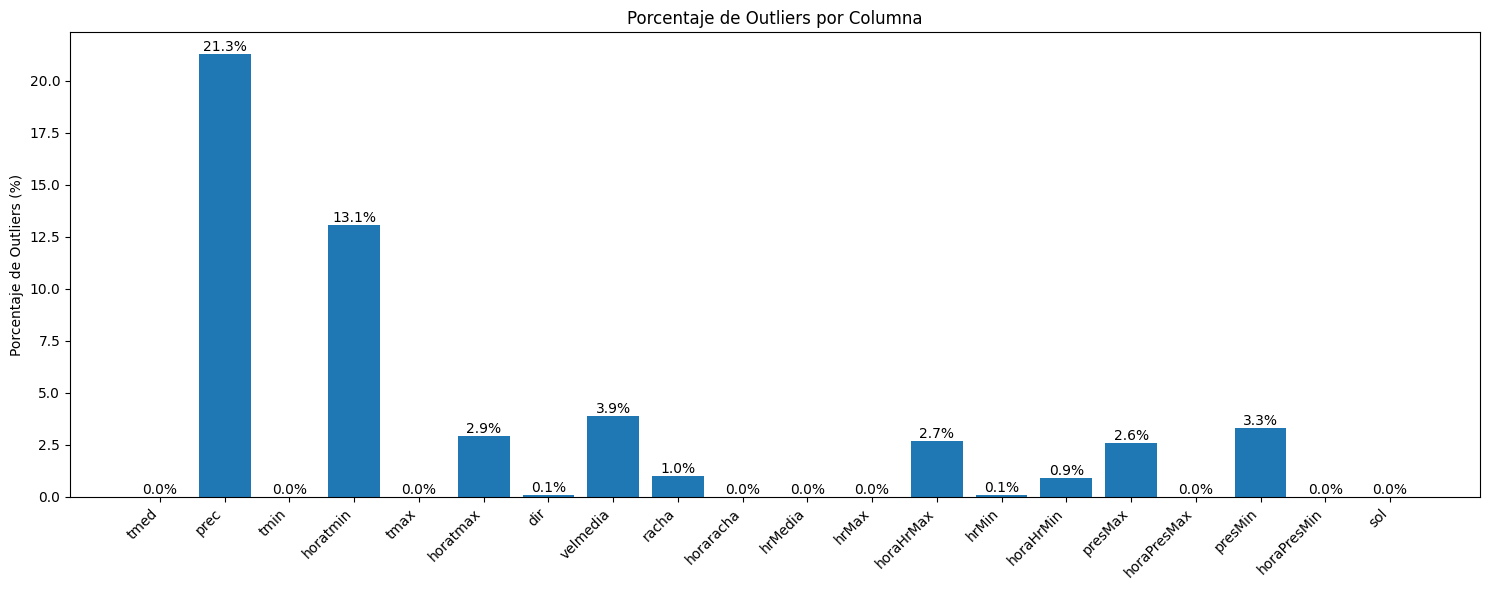

Columna tmed:
- Outliers eliminados: 136. Es decir, un 0.35% de los datos.
- Límite inferior: -10.20
- Límite superior: 39.40

Columna prec:
- Outliers eliminados: 10630. Es decir, un 27.67% de los datos.
- Límite inferior: -0.15
- Límite superior: 0.25

Columna tmin:
- Outliers eliminados: 10630. Es decir, un 27.67% de los datos.
- Límite inferior: -11.10
- Límite superior: 30.50

Columna horatmin:
- Outliers eliminados: 14169. Es decir, un 36.89% de los datos.
- Límite inferior: 2.75
- Límite superior: 9.55

Columna tmax:
- Outliers eliminados: 14169. Es decir, un 36.89% de los datos.
- Límite inferior: -9.70
- Límite superior: 48.70

Columna horatmax:
- Outliers eliminados: 15069. Es decir, un 39.23% de los datos.
- Límite inferior: 10.75
- Límite superior: 17.55

Columna dir:
- Outliers eliminados: 19961. Es decir, un 51.97% de los datos.
- Límite inferior: -26.50
- Límite superior: 57.50

Columna velmedia:
- Outliers eliminados: 20527. Es decir, un 53.44% de los datos.
- Límite in

In [11]:
# Función para detectar y eliminar outliers usando el método IQR
def eliminar_outliers(df, columnas):
    df_limpio = df.copy()
    
    for columna in columnas:
        # Calcular Q1, Q3 y IQR
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        
        # Definir límites
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Filtrar outliers
        df_limpio = df_limpio[
            (df_limpio[columna] >= limite_inferior) & 
            (df_limpio[columna] <= limite_superior)
        ]
        
        print(f"Columna {columna}:")
        print(f"- Outliers eliminados: {len(df) - len(df_limpio)}. Es decir, un {((len(df) - len(df_limpio)) / len(df)) * 100:.2f}% de los datos.")
        print(f"- Límite inferior: {limite_inferior:.2f}")
        print(f"- Límite superior: {limite_superior:.2f}\n")
    
    return df_limpio

# Aplicar a columnas numéricas excluyendo fechas y horas
columnas_a_revisar = df.columns

# Calcular y visualizar los outliers por columna
outliers_por_columna = {}
for columna in columnas_a_revisar:
    # Calcular Q1, Q3 y IQR
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir límites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Identificar outliers
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    porcentaje_outliers = (len(outliers) / len(df)) * 100
    outliers_por_columna[columna] = porcentaje_outliers

# Visualizar los outliers por columna
plt.figure(figsize=(15, 6))
plt.bar(outliers_por_columna.keys(), outliers_por_columna.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel('Porcentaje de Outliers (%)')
plt.title('Porcentaje de Outliers por Columna')
for i, v in enumerate(outliers_por_columna.values()):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Eliminar outliers
df_limpio = eliminar_outliers(df, columnas_a_revisar)

# Mostrar dimensiones antes y después
print(f"Dimensiones originales: {df.shape}")
print(f"Dimensiones después de eliminar outliers: {df_limpio.shape}")

No se eliminan los outliers porque se pasaría a tener muy pocos datos

# 3. Visualizaciones de los datos

## 3.1 Precipitación

<Axes: xlabel='fecha'>

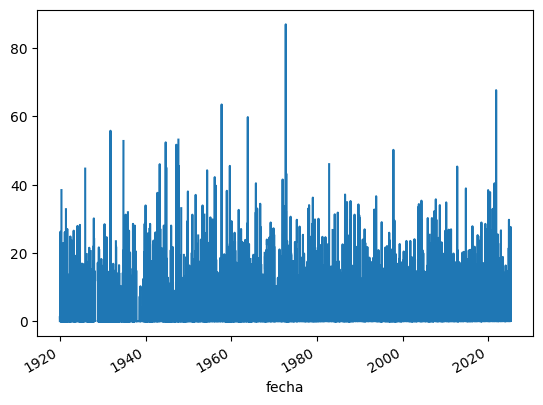

In [12]:
df["prec"].plot() # Gráfico de la precipitación con una frecuencia diaria

## Los datos son diarios, pero si se agrupan por años, es más visual

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\3673429006.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  precipitacion_anual = df['prec'].resample('Y').sum()


<Axes: xlabel='fecha'>

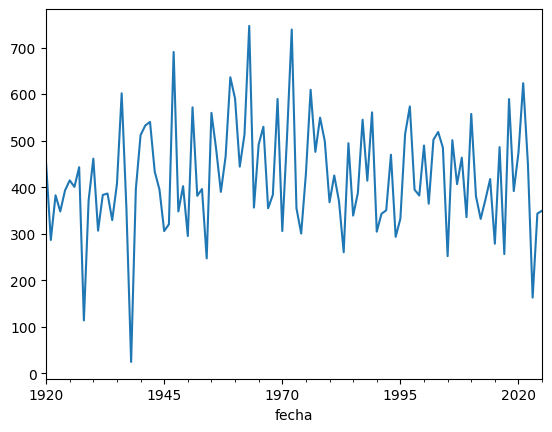

In [13]:
precipitacion_anual = df['prec'].resample('Y').sum()

precipitacion_anual.plot()

## 3.2 Temperatura

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\4109026544.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  temperaturas = df[['tmin','tmed','tmax']].resample('Y').mean()


<Axes: xlabel='fecha'>

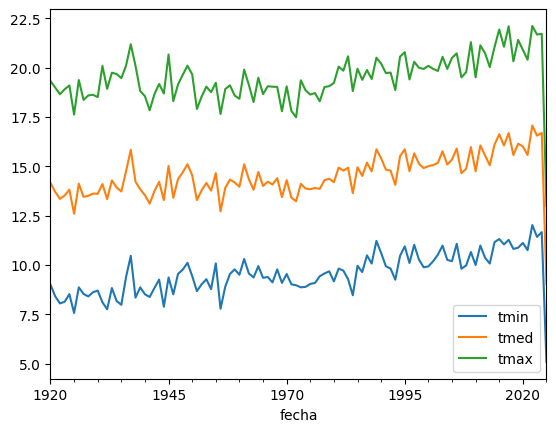

In [14]:
temperaturas = df[['tmin','tmed','tmax']].resample('Y').mean()

temperaturas.plot()

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\2497395775.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  hora_temperaturas = df[['horatmin','horatmax']].resample('Y').mean()


<Axes: xlabel='fecha'>

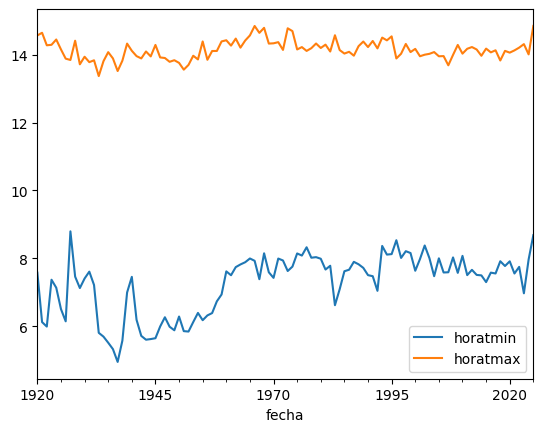

In [15]:
hora_temperaturas = df[['horatmin','horatmax']].resample('Y').mean()
hora_temperaturas.plot()

## 3.3 Insolación

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\3207120584.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  insolacion = df[['sol']].resample('Y').mean()


<Axes: xlabel='fecha'>

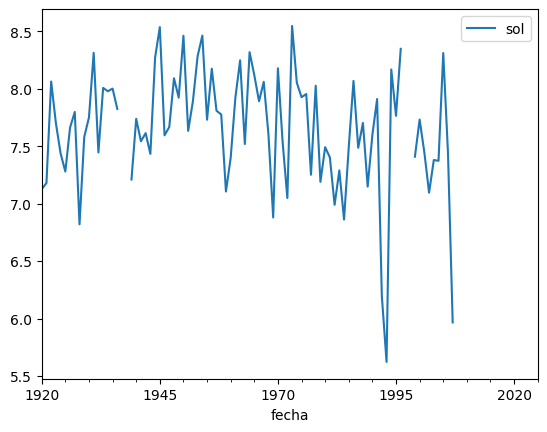

In [16]:
insolacion = df[['sol']].resample('Y').mean()
insolacion.plot()

## 3.4 Presión

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\2171022622.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  presiones = df[['presMin', 'presMax']].resample('Y').mean()


<Axes: xlabel='fecha'>

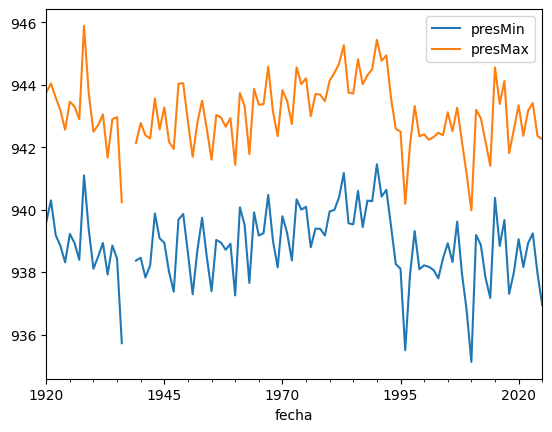

In [17]:
presiones = df[['presMin', 'presMax']].resample('Y').mean()
presiones.plot()

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\2036376267.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  hora_presiones = df[['horaPresMin', 'horaPresMax']].resample('Y').mean()


<Axes: xlabel='fecha'>

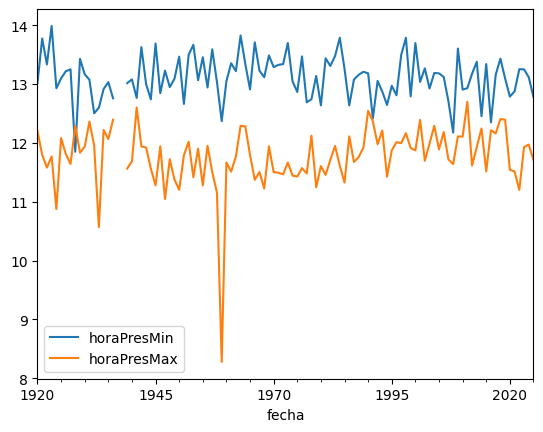

In [18]:
hora_presiones = df[['horaPresMin', 'horaPresMax']].resample('Y').mean()
hora_presiones.plot()

## 3.5 Humedad

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\2141779905.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  humedad = df[['hrMin', 'hrMedia', 'hrMax']].resample('Y').mean()


<Axes: xlabel='fecha'>

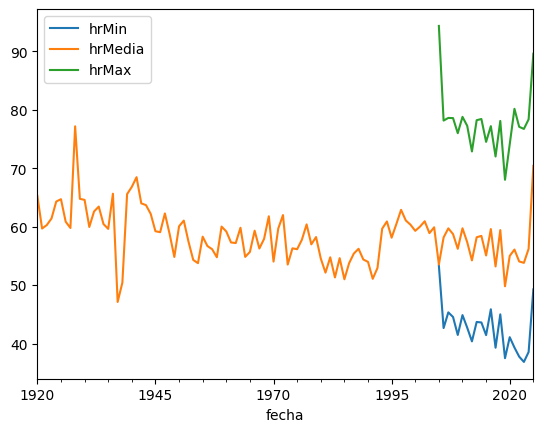

In [19]:
humedad = df[['hrMin', 'hrMedia', 'hrMax']].resample('Y').mean()
humedad.plot()

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\199392318.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  hora_humedades = df[['horaHrMin', 'horaHrMax']].resample('Y').mean()


<Axes: xlabel='fecha'>

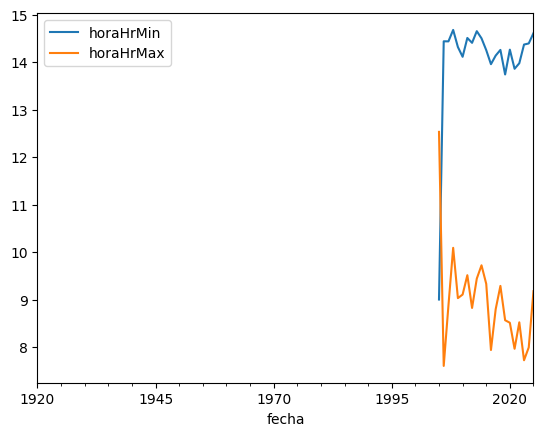

In [20]:
hora_humedades = df[['horaHrMin', 'horaHrMax']].resample('Y').mean()
hora_humedades.plot()

## 3.6 Viento

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\40040869.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  viento = df[['velmedia', 'racha']].resample('Y').mean()


<Axes: xlabel='fecha'>

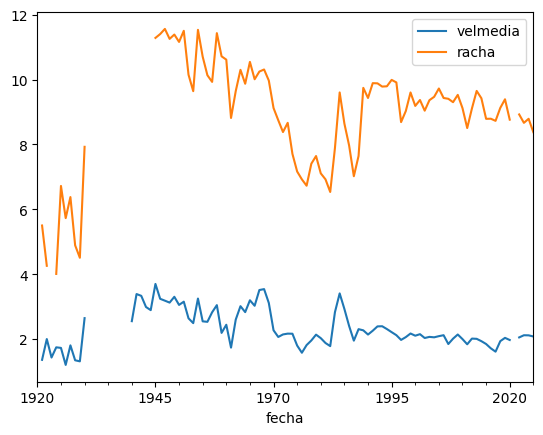

In [21]:
viento = df[['velmedia', 'racha']].resample('Y').mean()
viento.plot()

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\481535316.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  hora_viento = df[['horaracha']].resample('Y').mean()


<Axes: xlabel='fecha'>

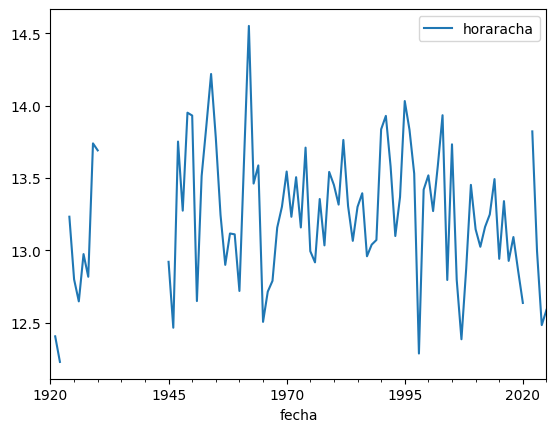

In [22]:
hora_viento = df[['horaracha']].resample('Y').mean()
hora_viento.plot()

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\2283382415.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  direccion_viento = df[['dir']].resample('Y').mean()


<Axes: xlabel='fecha'>

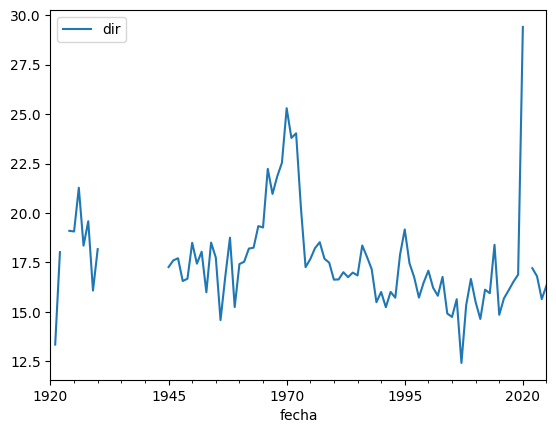

In [23]:
direccion_viento = df[['dir']].resample('Y').mean()
direccion_viento.plot()

## 3.7 Resumen estadístico del DataFrame

In [24]:
df.describe()

,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,presMax,horaPresMax,presMin,horaPresMin,sol
count,38275.000000,36038.000000,38275.00000,35760.000000,38277.000000,36106.000000,29427.000000,32983.000000,30004.000000,28828.000000,37038.000000,5952.000000,4297.000000,5951.000000,4518.000000,36948.000000,35492.000000,36948.000000,35313.000000,28654.000000
mean,14.558840,1.243701,9.58718,7.257065,19.530457,14.143000,17.584395,2.354052,8.967591,13.245592,58.225687,76.434308,8.755951,41.528315,14.244517,943.078386,11.757410,938.873027,13.123666,7.687189
std,7.401715,3.881364,6.46240,5.142773,8.593438,2.049279,11.131013,1.842536,4.052854,6.745151,18.254577,16.453640,7.059909,17.326819,3.728864,5.656901,8.856959,6.397460,7.962732,4.158511
min,-6.600000,0.000000,-10.10000,0.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,30.000000,0.000000,5.000000,0.000000,912.200000,0.000000,902.900000,0.000000,0.000000
25%,8.400000,0.000000,4.50000,5.300000,12.200000,13.300000,5.000000,1.100000,6.100000,9.100000,43.000000,63.000000,5.000000,28.000000,13.400000,939.800000,7.000000,935.500000,4.000000,4.600000
50%,13.700000,0.000000,9.00000,6.000000,18.600000,14.100000,20.000000,1.900000,8.600000,14.300000,56.000000,78.000000,6.300000,38.000000,15.000000,943.100000,10.000000,939.200000,17.000000,8.500000
75%,20.800000,0.100000,14.90000,7.000000,26.800000,15.000000,26.000000,3.100000,11.400000,18.000000,72.000000,92.000000,8.100000,53.000000,16.000000,946.500000,23.000000,942.800000,18.000000,11.000000
max,33.400000,87.000000,26.20000,23.590000,40.700000,23.590000,88.000000,16.900000,32.200000,23.590000,100.000000,100.000000,23.590000,98.000000,23.590000,967.300000,24.000000,962.300000,24.000000,14.900000


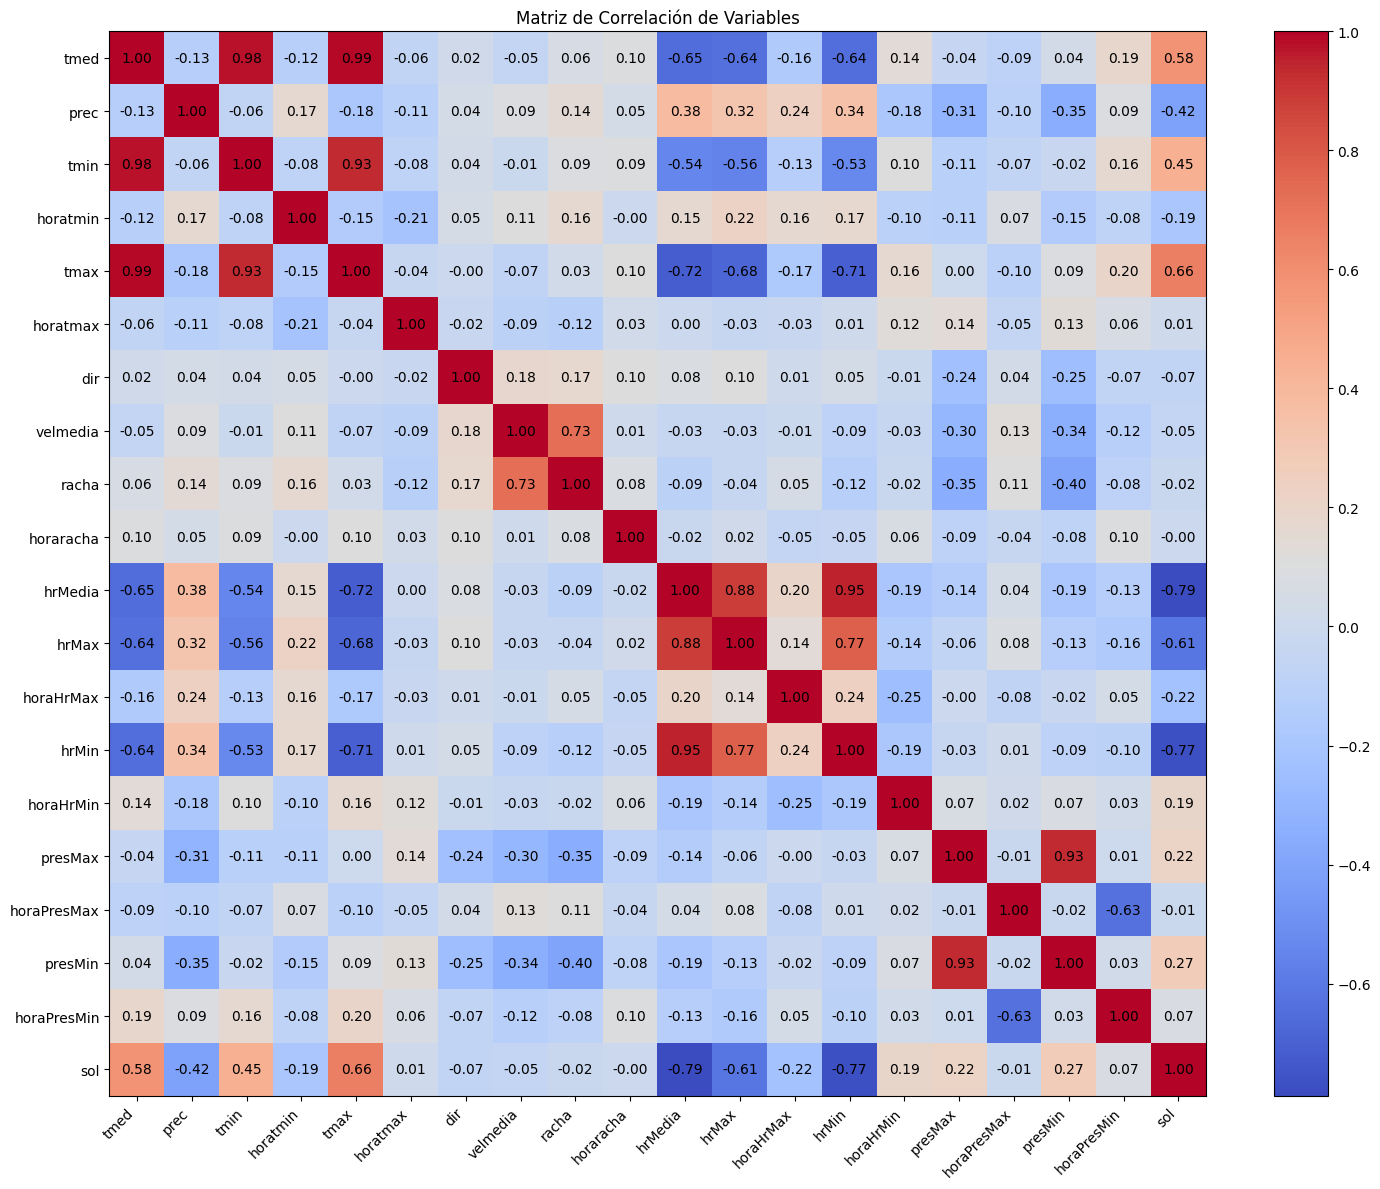

In [25]:
# Create correlation matrix
correlation_matrix = df.corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(15, 12))
im = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')

# Add colorbar
plt.colorbar(im)

# Add labels
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(correlation_matrix.columns)

# Add correlation values
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha='center', va='center')

plt.title('Matriz de Correlación de Variables')
plt.tight_layout()
plt.show()

# 4. Se prepara el DataFrame para un análisis de series temporales

## 4.1 Se define el período de tiempo que se analiza y se eliminan aquellos campos que tienen muchos valores nulos

Se obtiene la fecha mínima de la columna hrMin (la ultima fila con datos, ya que el dataframe está ordenado de forma descendente)

In [26]:
fecha_min_hrMin = df[df["hrMin"].notnull()].iloc[[-1]].index[0] 
fecha_min_hrMax = df[df["hrMax"].notnull()].iloc[[-1]].index[0]

print(f"Fecha mínima de hrMin: {fecha_min_hrMin}")
print(f"Fecha máxima de hrMin: {fecha_min_hrMax}")

Fecha mínima de hrMin: 2005-12-05 00:00:00
Fecha máxima de hrMin: 2005-12-05 00:00:00


La fecha mínima de la humedad máxima y mínima (que es la misma) sin valores nulos es el comienzo de las series temporales a analizar. 

In [27]:
filtro_st = df.index >= fecha_min_hrMin

In [28]:
df_st = df[filtro_st]
df_st

,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,presMax,horaPresMax,presMin,horaPresMin,sol
fecha,,,,,,,,,,,,,,,,,,,,
2025-04-03,9.5,20.2,8.3,7.00,10.7,0.10,15.0,2.2,7.8,0.2,98.0,NaN,NaN,NaN,NaN,935.2,11.0,930.9,3.0,NaN
2025-04-02,14.6,21.9,10.3,6.00,18.8,15.10,14.0,2.2,8.3,23.5,67.0,95.0,23.50,48.0,17.0,931.4,24.0,925.5,6.0,NaN
2025-04-01,16.9,0.0,10.1,5.20,23.7,14.00,11.0,1.9,7.2,15.0,42.0,71.0,23.59,26.0,14.0,935.4,0.0,927.2,24.0,NaN
2025-03-31,16.9,0.0,9.1,6.10,24.7,14.00,26.0,1.4,6.7,4.4,34.0,62.0,6.10,14.0,14.0,942.6,0.0,935.4,NaN,NaN
2025-03-30,12.6,0.0,4.2,6.50,20.9,16.10,23.0,2.2,8.3,9.1,33.0,69.0,6.40,16.0,15.1,943.6,10.0,940.8,17.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-09,9.1,0.0,4.6,6.55,13.6,13.00,20.0,2.5,11.1,13.1,65.0,NaN,NaN,NaN,NaN,951.9,23.0,947.9,16.0,7.9
2005-12-08,7.8,0.0,4.0,NaN,11.7,14.15,35.0,1.4,4.7,22.0,74.0,NaN,NaN,NaN,NaN,949.0,24.0,945.9,NaN,6.5
2005-12-07,7.6,0.0,4.3,NaN,10.8,14.00,25.0,1.1,16.1,14.3,69.0,NaN,NaN,NaN,NaN,946.9,24.0,941.5,0.0,8.0


In [29]:
df_st.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7059 entries, 2025-04-03 to 2005-12-05
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tmed         7037 non-null   float64
 1   prec         6899 non-null   float64
 2   tmin         7037 non-null   float64
 3   horatmin     6437 non-null   float64
 4   tmax         7037 non-null   float64
 5   horatmax     6670 non-null   float64
 6   dir          6089 non-null   float64
 7   velmedia     6345 non-null   float64
 8   racha        6273 non-null   float64
 9   horaracha    6071 non-null   float64
 10  hrMedia      6997 non-null   float64
 11  hrMax        5952 non-null   float64
 12  horaHrMax    4297 non-null   float64
 13  hrMin        5951 non-null   float64
 14  horaHrMin    4518 non-null   float64
 15  presMax      6995 non-null   float64
 16  horaPresMax  6328 non-null   float64
 17  presMin      6995 non-null   float64
 18  horaPresMin  6274 non-null   f

El campo "sol" tiene un 92,4 % de datos nulos. El resto de campos no supera el 50 % de valores nulos

In [30]:
(df_st.isna().sum() / len(df_st) * 100).round(1).sort_values(ascending = False)

sol            92.4
horaHrMax      39.1
horaHrMin      36.0
hrMax          15.7
hrMin          15.7
horaracha      14.0
dir            13.7
horaPresMin    11.1
racha          11.1
horaPresMax    10.4
velmedia       10.1
horatmin        8.8
horatmax        5.5
prec            2.3
presMin         0.9
hrMedia         0.9
presMax         0.9
tmax            0.3
tmin            0.3
tmed            0.3
dtype: float64

Se elimina el campo "sol"

In [31]:
df_st.drop("sol", axis = 1, inplace = True)

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\3900998306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_st.drop("sol", axis = 1, inplace = True)


## 4.2 Sustitución de los valores nulos

Los valores nulos son sustituidos por la media entre los 15 valores más cercanos

In [32]:
imputer = KNNImputer(n_neighbors = 1)
df_st_imputed = imputer.fit_transform(df_st)
df_st = pd.DataFrame(df_st_imputed, columns = df_st.columns, index = df_st.index)
df_st.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7059 entries, 2025-04-03 to 2005-12-05
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tmed         7059 non-null   float64
 1   prec         7059 non-null   float64
 2   tmin         7059 non-null   float64
 3   horatmin     7059 non-null   float64
 4   tmax         7059 non-null   float64
 5   horatmax     7059 non-null   float64
 6   dir          7059 non-null   float64
 7   velmedia     7059 non-null   float64
 8   racha        7059 non-null   float64
 9   horaracha    7059 non-null   float64
 10  hrMedia      7059 non-null   float64
 11  hrMax        7059 non-null   float64
 12  horaHrMax    7059 non-null   float64
 13  hrMin        7059 non-null   float64
 14  horaHrMin    7059 non-null   float64
 15  presMax      7059 non-null   float64
 16  horaPresMax  7059 non-null   float64
 17  presMin      7059 non-null   float64
 18  horaPresMin  7059 non-null   f

## 4.3 Coherencia en las sustitución de los valores nulos

Los datos imputados tienen que tener coherencia. Por ejemplo, no se pueden imputar valores de temperatura máxima por debajo de la temperatura mínima. En el caso de las horas, la lógica es distinta, ya que la temperatura máxima puede dar lugar antes de la mínima, por lo que no se puede aplicar la misma lógica. 

En el caso de las horas, se puede imputar la hora de la temperatura máxima por debajo de la mínima y viceversa. Por lo tanto, hay que tener en cuenta la lógica de cada campo a la hora de imputar los datos.

### 4.3.1 Se crea la funcion `correccion_imputador` y el diccionario `campos_a_corregir`

In [33]:
def correccion_imputador(v_min, v_med, v_max):
    """"
    Función para corregir los valores imputados por el KNNImputer. Se asegura de que los valores mínimos, máximos y medios sean coherentes entre sí.
    """
    if v_min > v_med:
        v_min = v_med
    if v_max < v_med:
        v_max = v_med
        
    return v_min, v_med, v_max

In [34]:
campos_a_corregir = {
    'temperatura': ['tmin', 'tmed', 'tmax'],
    'humedad': ['hrMin', 'hrMedia', 'hrMax'],
    'viento' : ['velmedia', 'racha'],
    'presion': ['presMin', 'presMax'],
}

Hay campos que no tienen valores coherentes. Este es un ejemplo

In [35]:
df_st[campos_a_corregir['humedad']][df_st[campos_a_corregir['humedad'][0]] > df_st[campos_a_corregir['humedad'][1]]]

,hrMin,hrMedia,hrMax
fecha,,,
2025-01-23,68.0,34.0,99.0
2025-01-10,64.0,34.0,95.0
2025-01-04,73.0,34.0,92.0
2024-11-09,66.0,34.0,99.0
2024-11-05,66.0,34.0,99.0
2024-10-21,39.0,34.0,90.0
2024-02-12,63.0,49.0,94.0
2020-09-22,37.0,34.0,89.0
2017-12-05,44.0,34.0,90.0


### 4.3.2 Se ejecuta la funcion `correccion_imputador` para todos los elementos del diccionario `campos_a_corregir`

In [36]:
for grupo in campos_a_corregir.values():
    if len(grupo) == 3:  # For groups with min, med, max values
        df_st[grupo[0]], df_st[grupo[1]], df_st[grupo[2]] = zip(*df_st[grupo].apply(
            lambda x: correccion_imputador(x[0], x[1], x[2]), axis=1
        ))
    elif len(grupo) == 2:  # For groups with just min and max values
        df_st[grupo[0]], _, df_st[grupo[1]] = zip(*df_st[grupo].apply(
            lambda x: correccion_imputador(x[0], (x[0] + x[1])/2, x[1]), axis=1
        ))

C:\Users\felix\AppData\Local\Temp\ipykernel_4508\3508380965.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: correccion_imputador(x[0], x[1], x[2]), axis=1
C:\Users\felix\AppData\Local\Temp\ipykernel_4508\3508380965.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: correccion_imputador(x[0], x[1], x[2]), axis=1
C:\Users\felix\AppData\Local\Temp\ipykernel_4508\3508380965.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

## 4.4 Se particiona el dataset en 1 conjunto de entrenamiento y en otro de test

In [37]:
fila_separadora = 30

df_st_train = df_st.iloc[fila_separadora:]
df_st_train = df_st_train.sort_index(ascending = True)

df_st_test = df_st.iloc[:fila_separadora]
df_st_test = df_st_test.sort_index(ascending = True)

In [38]:
train_y = df_st_train['prec']
train_y = train_y.sort_index(ascending = True)
train_y

fecha
2005-12-05     0.0
2005-12-06     0.0
2005-12-07     0.0
2005-12-08     0.0
2005-12-09     0.0
              ... 
2025-02-28     2.0
2025-03-01    12.0
2025-03-02    17.6
2025-03-03    14.3
2025-03-04     2.1
Name: prec, Length: 7029, dtype: float64

In [39]:
test_y = df_st_test['prec']
test_y = test_y.sort_index(ascending = True)
test_y

fecha
2025-03-05     4.4
2025-03-06    16.1
2025-03-07    21.9
2025-03-08    13.8
2025-03-09     3.6
2025-03-10    23.5
2025-03-11     7.5
2025-03-12     0.0
2025-03-13     4.7
2025-03-14     0.0
2025-03-15     6.7
2025-03-16     0.4
2025-03-17    16.7
2025-03-18    20.9
2025-03-19     0.0
2025-03-20    27.6
2025-03-21    14.5
2025-03-22     2.3
2025-03-23     0.0
2025-03-24     4.8
2025-03-25     0.0
2025-03-26     0.0
2025-03-27     0.0
2025-03-28     0.0
2025-03-29     0.0
2025-03-30     0.0
2025-03-31     0.0
2025-04-01     0.0
2025-04-02    21.9
2025-04-03    20.2
Name: prec, dtype: float64

In [40]:
train_x = df_st_train.drop(columns=['prec']).sort_index(ascending = True)
train_x

,tmed,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,presMax,horaPresMax,presMin,horaPresMin
fecha,,,,,,,,,,,,,,,,,,
2005-12-05,8.7,5.4,5.20,12.0,12.55,17.0,2.2,12.5,10.0,73.0,95.0,7.00,37.0,14.0,937.9,22.0,934.9,7.0
2005-12-06,6.3,2.2,6.30,10.4,13.30,30.0,1.1,7.5,8.4,68.0,92.0,6.30,42.0,15.5,941.5,24.0,936.3,5.0
2005-12-07,7.6,4.3,7.30,10.8,14.00,25.0,1.1,16.1,14.3,69.0,89.0,8.00,50.0,15.0,946.9,24.0,941.5,0.0
2005-12-08,7.8,4.0,8.10,11.7,14.15,35.0,1.4,4.7,22.0,74.0,95.0,5.40,52.0,14.4,949.0,24.0,945.9,2.0
2005-12-09,9.1,4.6,6.55,13.6,13.00,20.0,2.5,11.1,13.1,65.0,80.0,2.50,46.0,16.5,951.9,23.0,947.9,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,11.0,6.1,6.00,16.0,15.40,10.0,3.1,7.8,20.5,58.0,80.0,5.00,42.0,16.3,939.6,0.0,934.5,16.0
2025-03-01,7.4,4.0,23.59,10.8,0.10,23.0,3.3,9.2,2.0,94.0,98.0,1.00,64.0,0.0,940.7,23.0,936.0,4.0
2025-03-02,3.7,2.5,8.00,4.9,20.10,5.0,4.2,11.1,0.3,96.0,99.0,23.59,89.0,3.2,941.5,9.0,939.6,18.0


# 5. Predicción de 30 días con datos de frecuencia DIARIA

## 5.1 ARIMA sin Exógenas

Se utiliza `pmdarima.auto_arima` para encontrar un modelo ARIMA apropiado. Esto facilitará la búsqueda de parámetros p, d, q adecuados.

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [41]:
warnings.filterwarnings("ignore")

stepwise_model = auto_arima(
    train_y,
    start_p=0,
    start_q=0,
    max_p=30,
    max_q=30,
    seasonal=True,
    trace=True,
    suppress_warnings=True,
    error_action='raise'
)
stepwise_model.fit(train_y)
forecast_arima = stepwise_model.predict(n_periods=len(test_y))
forecast_arima = pd.Series(forecast_arima)
forecast_arima.index = test_y.index

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=39778.963, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39385.354, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=39451.524, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=40403.265, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=39334.491, Time=0.45 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=39322.999, Time=0.72 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=39323.000, Time=0.92 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=39311.736, Time=6.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=39317.543, Time=2.87 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=39310.657, Time=6.85 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=39322.609, Time=9.44 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=39311.059, Time=6.53 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=39311.365, Time=10.48 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=39323.202, Time=1.08 sec
 ARIMA(5,0,2)(0,0,

In [42]:
rmse_arima = root_mean_squared_error(test_y, forecast_arima)
mae_arima = mean_absolute_error(test_y, forecast_arima)
mape_arima = mean_absolute_percentage_error(test_y, forecast_arima)

print("ARIMA (sin exógenas) Métricas:")
print("RMSE:", rmse_arima)
print("MAE:", mae_arima)
print(f"MAPE: {mape_arima:.2%}")

ARIMA (sin exógenas) Métricas:
RMSE: 10.833483319643053
MAE: 7.328296579518436
MAPE: 271639336303597600.00%


## 5.2 ARIMA con Exógenas

In [43]:
warnings.filterwarnings("ignore")

stepwise_model_exog = auto_arima(
    train_y,
    X = train_x,
    start_p=0,
    start_q=0,
    max_p=30,
    max_q=30,
    seasonal=True,
    trace=True,
    suppress_warnings=True,
    error_action='raise'
)
stepwise_model_exog.fit(train_y)
forecast_arima_exog = stepwise_model_exog.predict(n_periods=len(test_y))
forecast_arima_exog = pd.Series(forecast_arima_exog)
forecast_arima_exog.index = test_y.index

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41589.857, Time=4.39 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39817.507, Time=9.90 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37624.287, Time=17.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41587.857, Time=7.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=37554.163, Time=19.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=20.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=37606.686, Time=23.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=37558.654, Time=23.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=39096.120, Time=14.69 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=25.54 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=16.91 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 182.966 seconds


In [44]:
exog_rmse_arima = root_mean_squared_error(test_y, forecast_arima_exog)
exog_mae_arima = mean_absolute_error(test_y, forecast_arima_exog)
exog_mape_arima = mean_absolute_percentage_error(test_y, forecast_arima_exog)

print("ARIMA (con exógenas) Métricas:")
print("RMSE:", exog_rmse_arima)
print("MAE:", exog_mae_arima)
print(f"MAPE: {exog_mape_arima:.2%}")

ARIMA (con exógenas) Métricas:
RMSE: 11.118261748149761
MAE: 7.5154643935373775
MAPE: 223971846945447360.00%


## 5.3 Resultados graficados

<Axes: xlabel='fecha'>

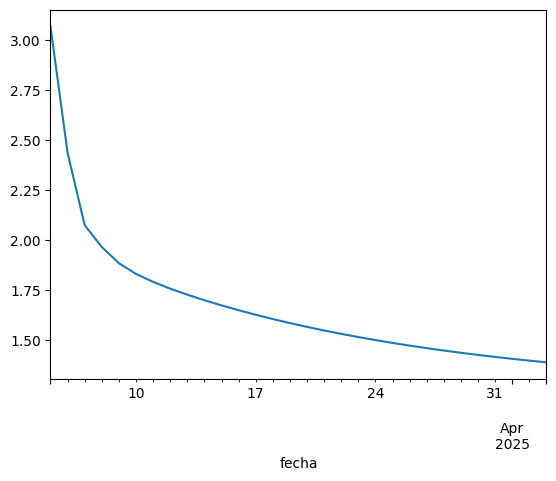

In [45]:
forecast_arima.plot()

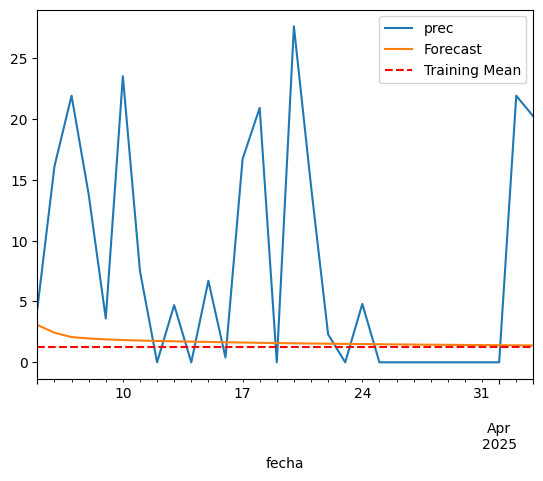

In [46]:
test_y.plot()
forecast_arima.plot(label='Forecast')
plt.axhline(y=train_y.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()

<Axes: xlabel='fecha'>

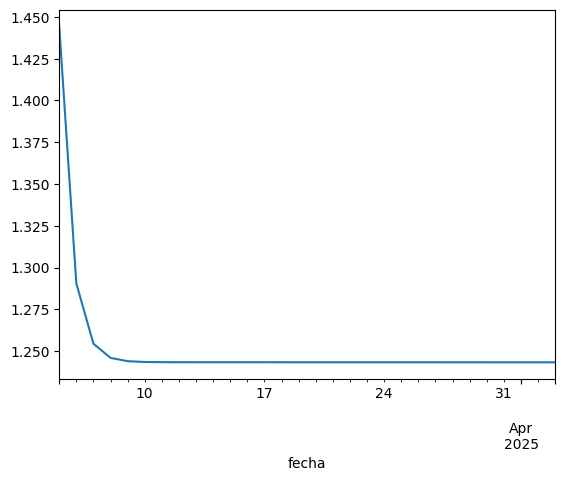

In [47]:
forecast_arima_exog.plot()

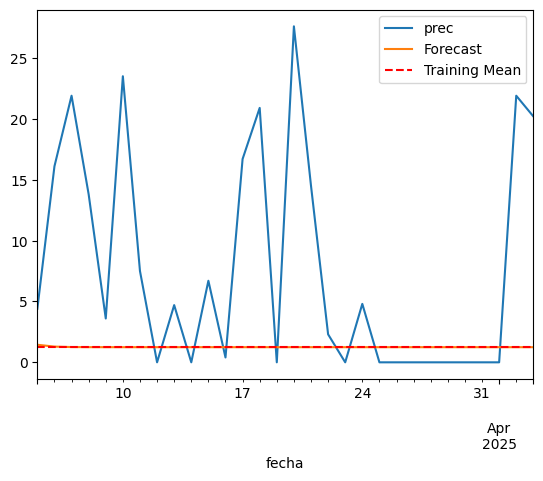

In [48]:
test_y.plot()
forecast_arima_exog.plot(label='Forecast')
plt.axhline(y=train_y.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()

# 6. Predicción de 30 días con datos de frecuencia SEMANAL

In [49]:
train_y_semanal = df_st_train['prec'].resample('W').mean()
train_x_semanal = df_st_train.drop(columns=['prec']).resample('W').mean()
test_y_semanal = df_st_test['prec'].resample('W').mean().iloc[0:4] # 30 días de test son 4 semanas y 2 días. Por lo tanto, se queda con 4 semanas

## 6.1 ARIMA sin Exógenas

In [50]:
warnings.filterwarnings("ignore")

stepwise_model_semanal = auto_arima(
    train_y_semanal,
    start_p=0,
    start_q=0,
    max_p=30,
    max_q=30,
    seasonal=True,
    trace=True,
    suppress_warnings=True,
    error_action='raise'
)
stepwise_model_semanal.fit(train_y_semanal)
forecast_arima_semanal = stepwise_model_semanal.predict(n_periods=len(test_y_semanal))
forecast_arima_semanal = pd.Series(forecast_arima_semanal)
forecast_arima_semanal.index = test_y_semanal.index

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4352.261, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4322.602, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4325.665, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4656.235, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4322.023, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4319.370, Time=0.22 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4321.370, Time=0.30 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4321.370, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4320.896, Time=0.47 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=4323.367, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4419.962, Time=0.08 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 1.957 seconds


In [51]:
rmse_arima_semanal = root_mean_squared_error(test_y_semanal, forecast_arima_semanal)
mae_arima_semanal = mean_absolute_error(test_y_semanal, forecast_arima_semanal)
mape_arima_semanal = mean_absolute_percentage_error(test_y_semanal, forecast_arima_semanal)

print("ARIMA (sin exógenas) Métricas:")
print("RMSE:", rmse_arima_semanal)
print("MAE:", mae_arima_semanal)
print(f"MAPE: {mape_arima_semanal:.2%}")

ARIMA (sin exógenas) Métricas:
RMSE: 7.148089764797159
MAE: 6.061474066307476
MAPE: 86.48%


## 6.2 ARIMA con Exógenas

In [52]:
warnings.filterwarnings("ignore")

stepwise_model_semanal_exog = auto_arima(
    train_y_semanal,
    X = train_x_semanal,
    start_p=0,
    start_q=0,
    max_p=30,
    max_q=30,
    seasonal=True,
    trace=True,
    suppress_warnings=True,
    error_action='raise'
)
stepwise_model_semanal_exog.fit(train_y_semanal)
forecast_arima_exog_semanal = stepwise_model_semanal_exog.predict(n_periods=len(test_y_semanal))
forecast_arima_exog_semanal = pd.Series(forecast_arima_exog_semanal)
forecast_arima_exog_semanal.index = test_y_semanal.index

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4270.744, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4046.900, Time=2.69 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3770.926, Time=3.72 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4268.747, Time=1.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3759.350, Time=3.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3761.767, Time=3.73 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3769.288, Time=5.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3758.763, Time=3.87 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3758.814, Time=4.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3759.688, Time=4.74 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3754.374, Time=3.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3767.899, Time=4.38 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3767.138, Time=3.92 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3753.951, Time=4.77 sec
 ARIMA(1,1,3)(0,0,0)[0]          

In [53]:
exog_rmse_arima_semanal = root_mean_squared_error(test_y_semanal, forecast_arima_exog_semanal)
exog_mae_arima_semanal = mean_absolute_error(test_y_semanal, forecast_arima_exog_semanal)
exog_mape_arima_semanal = mean_absolute_percentage_error(test_y_semanal, forecast_arima_exog_semanal)

print("ARIMA (con exógenas) Métricas:")
print("RMSE:", exog_rmse_arima_semanal)
print("MAE:", exog_mae_arima_semanal)
print(f"MAPE: {exog_mape_arima_semanal:.2%}")

ARIMA (con exógenas) Métricas:
RMSE: 7.4044331921445075
MAE: 6.246126633755549
MAPE: 81.32%


## 6.3 Resultados graficados

<Axes: xlabel='fecha'>

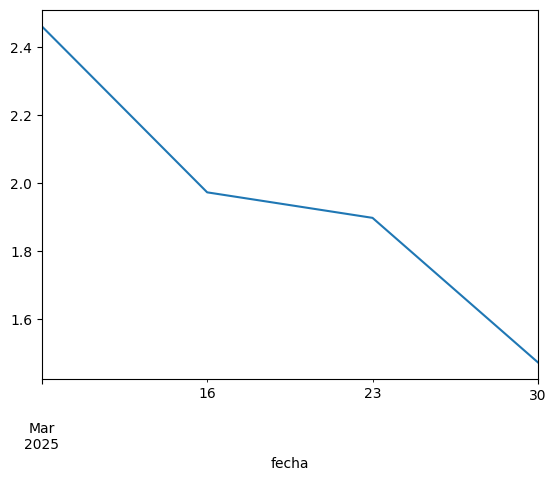

In [54]:
forecast_arima_semanal.plot()

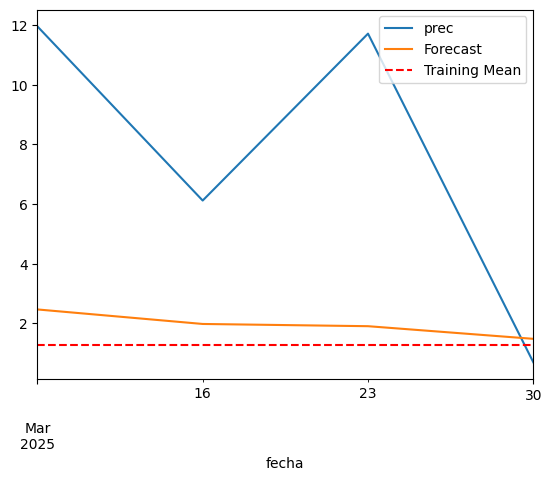

In [55]:
test_y_semanal.plot()
forecast_arima_semanal.plot(label='Forecast')
plt.axhline(y=train_y_semanal.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()

<Axes: xlabel='fecha'>

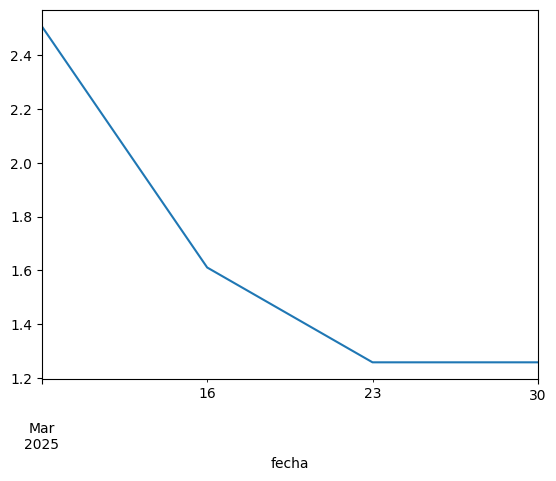

In [56]:
forecast_arima_exog_semanal.plot()

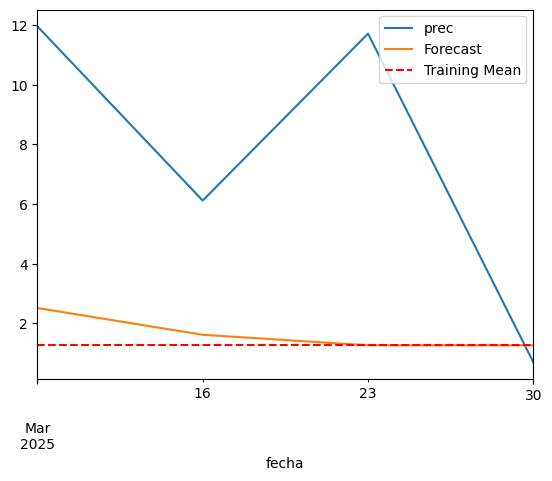

In [57]:
test_y_semanal.plot()
forecast_arima_exog_semanal.plot(label='Forecast')
plt.axhline(y=train_y_semanal.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()

# 7. Predicción de 30 días con datos de frecuencia MENSUAL

In [58]:
train_y_mensual = df_st_train['prec'].resample('M').mean()
train_x_mensual = df_st_train.drop(columns=['prec']).resample('M').mean()
test_y_mensual = df_st_test['prec'].resample('M').mean()

## 7.1 ARIMA sin Exógenas

In [59]:
warnings.filterwarnings("ignore")

stepwise_model_mensual = auto_arima(
    train_y_mensual,
    start_p=0,
    start_q=0,
    max_p=30,
    max_q=30,
    seasonal=True,
    trace=True,
    suppress_warnings=True,
    error_action='raise'
)
stepwise_model_mensual.fit(train_y_mensual)
forecast_arima_mensual = stepwise_model_mensual.predict(n_periods=len(test_y_mensual))
forecast_arima_mensual = pd.Series(forecast_arima_mensual)
forecast_arima_mensual.index = test_y_mensual.index

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=793.543, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=789.222, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=789.023, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=946.088, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=790.932, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=790.537, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=791.882, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=888.432, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.383 seconds


In [60]:
rmse_arima_mensual= root_mean_squared_error(test_y_mensual, forecast_arima_mensual)
mae_arima_mensual= mean_absolute_error(test_y_mensual, forecast_arima_mensual)
mape_arima_mensual= mean_absolute_percentage_error(test_y_mensual, forecast_arima_mensual)

print("ARIMA (sin exógenas) Métricas:")
print("RMSE:", rmse_arima_mensual)
print("MAE:", mae_arima_mensual)
print(f"MAPE: {mape_arima_mensual:.2%}")

ARIMA (sin exógenas) Métricas:
RMSE: 9.389872993150327
MAE: 8.24916424522339
MAPE: 72.20%


## 7.2 ARIMA con Exógenas

In [61]:
warnings.filterwarnings("ignore")

stepwise_model_exog_mensual = auto_arima(
    train_y_mensual,
    X = train_x_mensual,
    start_p=0,
    start_q=0,
    max_p=30,
    max_q=30,
    seasonal=True,
    trace=True,
    suppress_warnings=True,
    error_action='raise'
)
stepwise_model_exog_mensual.fit(train_y_mensual)
forecast_arima_exog_mensual = stepwise_model_exog_mensual.predict(n_periods=len(test_y_mensual))
forecast_arima_exog_mensual = pd.Series(forecast_arima_exog_mensual)
forecast_arima_exog_mensual.index = test_y_mensual.index

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=736.632, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=687.236, Time=1.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=621.226, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=734.730, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=625.637, Time=1.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=623.784, Time=1.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=621.978, Time=1.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=620.514, Time=1.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=622.522, Time=1.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=621.777, Time=1.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=685.414, Time=0.98 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=623.307, Time=1.34 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 13.755 seconds


In [62]:
exog_rmse_arima_mensual = root_mean_squared_error(test_y_mensual, forecast_arima_exog_mensual)
exog_mae_arima_mensual = mean_absolute_error(test_y_mensual, forecast_arima_exog_mensual)
exog_mape_arima_mensual = mean_absolute_percentage_error(test_y_mensual, forecast_arima_exog_mensual)

print("ARIMA (con exógenas) Métricas:")
print("RMSE:", exog_rmse_arima_mensual)
print("MAE:", exog_mae_arima_mensual)
print(f"MAPE: {exog_mape_arima_mensual:.2%}")

ARIMA (con exógenas) Métricas:
RMSE: 9.8776302715004
MAE: 9.233237743704223
MAPE: 86.20%


## 7.3 Resultados graficados

<Axes: xlabel='fecha'>

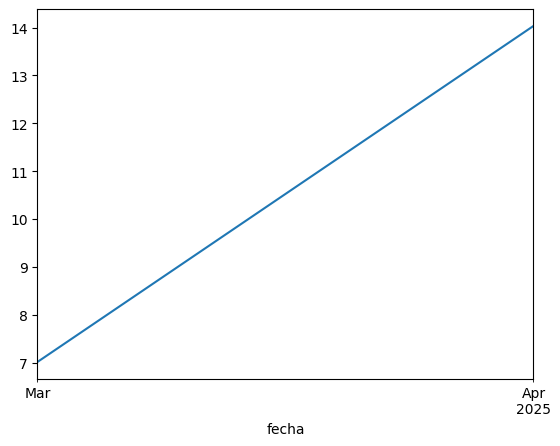

In [63]:
test_y_mensual.plot()

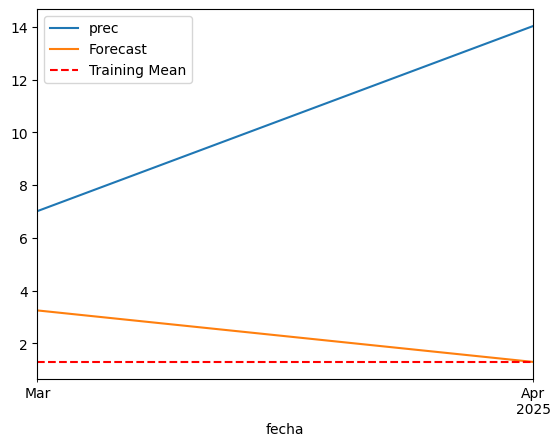

In [64]:
test_y_mensual.plot()
forecast_arima_mensual.plot(label='Forecast')
plt.axhline(y=train_y_mensual.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()

<Axes: xlabel='fecha'>

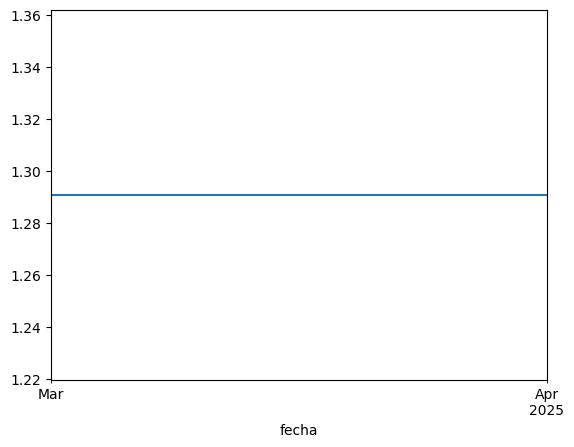

In [65]:
forecast_arima_exog_mensual.plot()

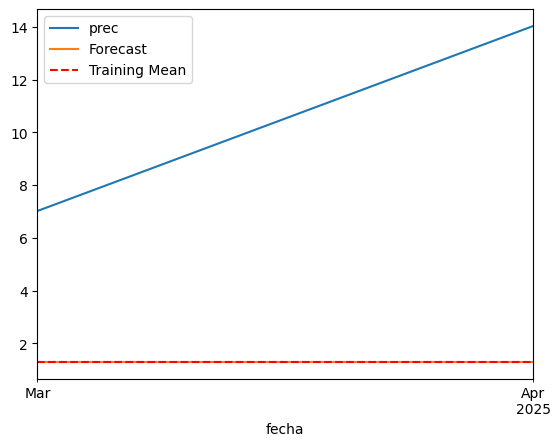

In [66]:
test_y_mensual.plot()
forecast_arima_exog_mensual.plot(label='Forecast')
plt.axhline(y=train_y_mensual.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()

# 8. Exportación de los conjuntos de datos creados

In [67]:
df.to_excel('df.xlsx')
df_st.to_excel('df_st.xlsx')
df_st_train.to_excel('df_st_train.xlsx')
df_st_test.to_excel('df_st_test.xlsx')

# Conjuntos de entrenamiento

train_x.to_excel('train_x.xlsx')
train_x_semanal.to_excel('train_x_semanal.xlsx')
train_x_mensual.to_excel('train_x_mensual.xlsx')

train_y.to_excel('train_y.xlsx')
train_y_semanal.to_excel('train_y_semanal.xlsx')
train_y_mensual.to_excel('train_y_mensual.xlsx')

# Conjuntos de test

test_y.to_excel('test_y.xlsx')
test_y_semanal.to_excel('test_y_semanal.xlsx')
test_y_mensual.to_excel('test_y_mensual.xlsx')

In [68]:
datos_arima = {
    "Modelo": [
        "ARIMA (sin exógenas)",
        "ARIMA (con exógenas)",
        "ARIMA (semanal sin exógenas)",
        "ARIMA (semanal con exógenas)",
        "ARIMA (mensual sin exógenas)",
        "ARIMA (mensual con exógenas)"
    ],
    "Parámetros óptimos": [
        str(stepwise_model.order),
        str(stepwise_model_exog.order),
        str(stepwise_model_semanal.order),
        str(stepwise_model_semanal_exog.order),
        str(stepwise_model_mensual.order),
        str(stepwise_model_exog_mensual.order)
    ]
}

# Crear DataFrame
df = pd.DataFrame(datos_arima)

# Guardar en Excel
df.to_excel("parametros_ARIMA_optimos.xlsx", index=False)

# 9. Forecast rolling se ajusta más a la serie temporal de acuerdo con lo visto en el siguiente notebook:

https://github.com/Ag994/time-series-analysis-and-forecasting-Using-Arima-auto-Arima-and-prophet/blob/main/time%20series%20analysis.ipynb

In [69]:
# Versión con predicción futura
# Crear Series con índices predefinidos y añadir 30 días más

df_st_mensual = df_st.resample('M').mean().sort_index(ascending=True)

# Crear índice extendido (30 días más)
ultimo_dia = df_st_mensual.index[-1]
dias_adicionales = pd.date_range(start=ultimo_dia, periods=31, freq='M')[1:]
indice_extendido = df_st_mensual.index[30:].union(dias_adicionales)

# Crear Series con el índice extendido
predictions = pd.Series(index=indice_extendido)

# Realizar predicciones históricas
for i in range(30, len(df_st_mensual)):
    window_data = df_st.iloc[i-30:i]
    model = ARIMA(
        order=stepwise_model_mensual.order,
        seasonal_order=stepwise_model_mensual.seasonal_order,
        suppress_warnings=True
    )
    results = model.fit(window_data['prec'])
    forecast = results.predict(n_periods=1)
    predictions.iloc[i-30] = float(forecast)

# Realizar predicciones futuras
ultima_ventana = df_st.iloc[-30:]
model = ARIMA(
    order=stepwise_model_mensual.order,
    seasonal_order=stepwise_model_mensual.seasonal_order,
    suppress_warnings=True
)
results = model.fit(ultima_ventana['prec'])
forecast_future = results.predict(n_periods=30)

# Asignar predicciones futuras
predictions.iloc[-30:] = forecast_future

# Asegurar que no hay valores negativos
predictions = predictions.clip(lower=0)

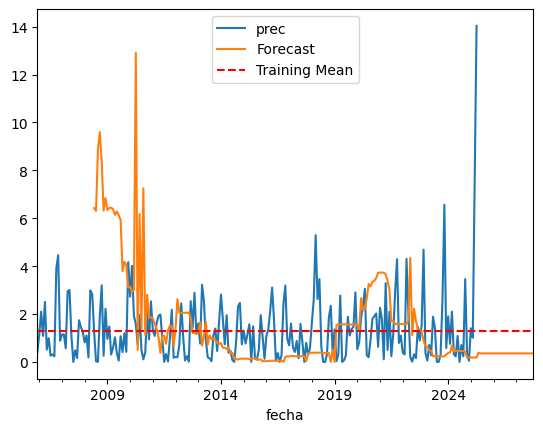

In [70]:
df_st_mensual["prec"].plot()
predictions.plot(label='Forecast')
plt.axhline(y=train_y_mensual.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()